# Классификация изображений из реального датасета (zip)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/chars.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 335/335 [00:01<00:00, 311.15it/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),    # приводим к единому размеру
    transforms.ToTensor(),            # преобразование в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # нормализация
])

full_dataset = datasets.ImageFolder('/content/chars', transform=transform)

train_size = int(0.7 * len(full_dataset))  # 70% для обучения
val_size = int(0.15 * len(full_dataset))   # 15% для валидации
test_size = len(full_dataset) - train_size - val_size  # остальные 15% для теста

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from collections import Counter

labels = [label for _, label in full_dataset.imgs]

label_counts = Counter(labels)

for class_index, count in label_counts.items():
    print(f'Класс {full_dataset.classes[class_index]}: {count} изображений')

Класс marvel: 193 изображений
Класс star-wars: 139 изображений


Выборка сбалансирована

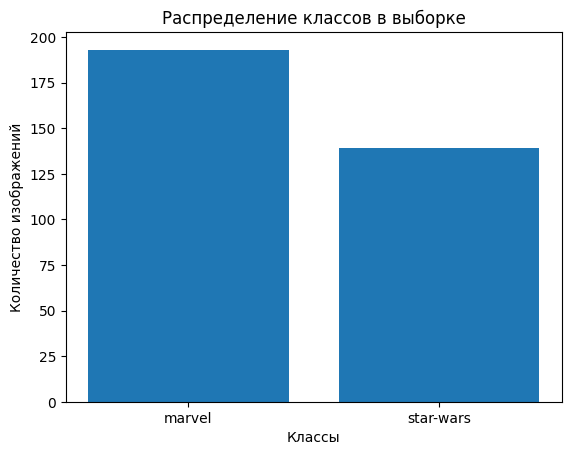

In [ ]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(range(len(full_dataset.classes)), full_dataset.classes)
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в выборке')
plt.show()

Выведем изображения:

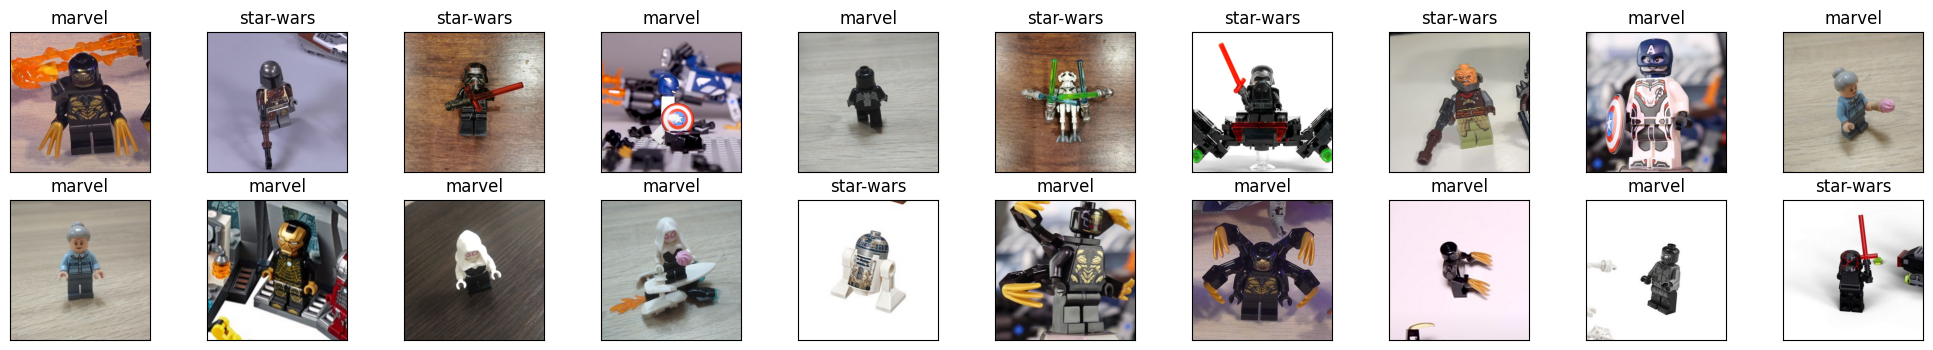

In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

classes = ['marvel', 'star-wars']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Изображения после приведения к единому размеру (100,100):

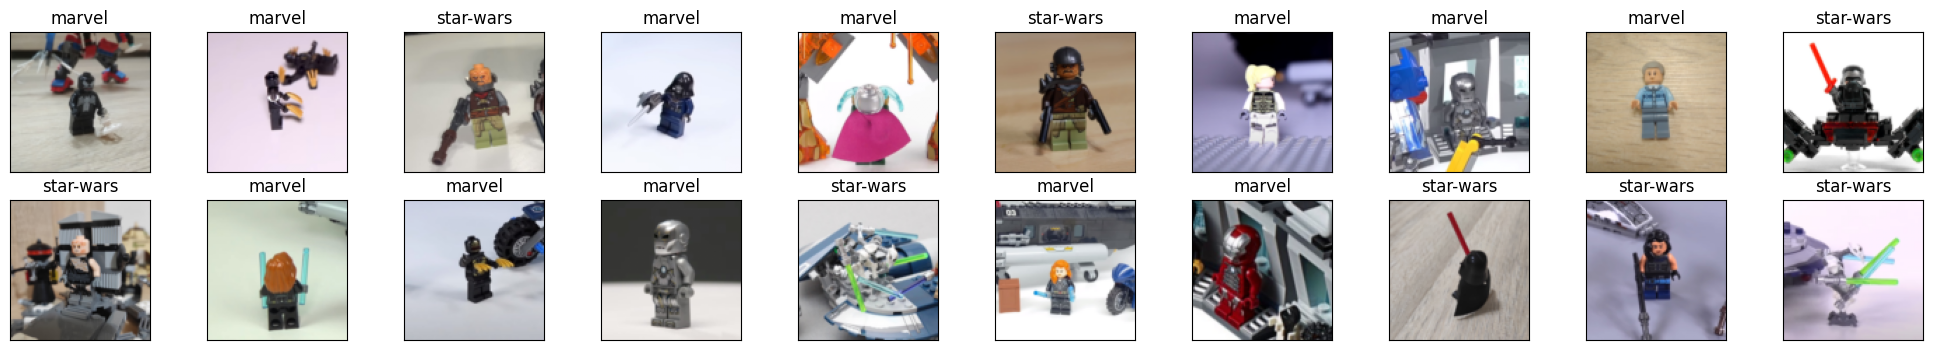

In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

classes = ['marvel', 'star-wars']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Архитектура модели

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # вход: 100x100x3 -> выход: 100x100x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # вход: 100x100x32 -> выход: 100x100x64
        self.pool = nn.MaxPool2d(2, 2)

        # после 2 слоев свертки и подвыборки размер изображения 25x25
        self.fc1 = nn.Linear(64 * 25 * 25, 512)  # учитываем новый размер
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # после conv1 -> 100x100 -> MaxPool -> 50x50
        x = self.pool(F.relu(self.conv2(x)))  # после conv2 -> 50x50 -> MaxPool -> 25x25
        x = x.view(-1, 64 * 25 * 25)  # преобразуем тензор в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Обучение

In [ ]:
train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0

        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train / len(train_loader)
        epoch_loss_val = epoch_loss_val / len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    #return train_losses, val_losses, train_labels, train_preds, val_labels, val_preds

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Train Loss: 0.9864, Val Loss: 0.6770,
 Train Acc: 51.29%, Val Acc: 59.18%,
 Train F1: 0.51, Val F1: 0.44,
 Train MAE: 0.4871, Val MAE: 0.4082, Time: 8.64s




Epoch [2/15], Train Loss: 0.6600, Val Loss: 0.6568,
 Train Acc: 59.48%, Val Acc: 59.18%,
 Train F1: 0.51, Val F1: 0.44,
 Train MAE: 0.4461, Val MAE: 0.4082, Time: 8.51s




Epoch [3/15], Train Loss: 0.6237, Val Loss: 0.6594,
 Train Acc: 59.05%, Val Acc: 63.27%,
 Train F1: 0.50, Val F1: 0.47,
 Train MAE: 0.4339, Val MAE: 0.3946, Time: 9.12s




Epoch [4/15], Train Loss: 0.6063, Val Loss: 0.6422,
 Train Acc: 68.53%, Val Acc: 69.39%,
 Train F1: 0.53, Val F1: 0.56,
 Train MAE: 0.4041, Val MAE: 0.3724, Time: 7.63s




Epoch [5/15], Train Loss: 0.5396, Val Loss: 0.5931,
 Train Acc: 76.29%, Val Acc: 75.51%,
 Train F1: 0.58, Val F1: 0.61,
 Train MAE: 0.3707, Val MAE: 0.3469, Time: 9.38s




Epoch [6/15], Train Loss: 0.4613, Val Loss: 0.6428,
 Train Acc: 79.74%, Val Acc: 65.31%,
 Train F1: 0.62, Val F1: 0.63,
 Train MAE: 0.3427, Val MAE: 0.3469, Time: 7.64s




Epoch [7/15], Train Loss: 0.4272, Val Loss: 0.5426,
 Train Acc: 79.74%, Val Acc: 81.63%,
 Train F1: 0.65, Val F1: 0.66,
 Train MAE: 0.3227, Val MAE: 0.3236, Time: 9.25s




Epoch [8/15], Train Loss: 0.2946, Val Loss: 0.4889,
 Train Acc: 90.09%, Val Acc: 85.71%,
 Train F1: 0.69, Val F1: 0.68,
 Train MAE: 0.2947, Val MAE: 0.3010, Time: 8.52s




Epoch [9/15], Train Loss: 0.2843, Val Loss: 0.4384,
 Train Acc: 87.50%, Val Acc: 79.59%,
 Train F1: 0.71, Val F1: 0.70,
 Train MAE: 0.2759, Val MAE: 0.2902, Time: 8.15s




Epoch [10/15], Train Loss: 0.1586, Val Loss: 0.5767,
 Train Acc: 95.69%, Val Acc: 73.47%,
 Train F1: 0.74, Val F1: 0.70,
 Train MAE: 0.2526, Val MAE: 0.2878, Time: 9.01s




Epoch [11/15], Train Loss: 0.1180, Val Loss: 0.3941,
 Train Acc: 94.40%, Val Acc: 85.71%,
 Train F1: 0.76, Val F1: 0.72,
 Train MAE: 0.2347, Val MAE: 0.2746, Time: 7.73s




Epoch [12/15], Train Loss: 0.1052, Val Loss: 0.4265,
 Train Acc: 97.41%, Val Acc: 87.76%,
 Train F1: 0.77, Val F1: 0.73,
 Train MAE: 0.2173, Val MAE: 0.2619, Time: 9.15s




Epoch [13/15], Train Loss: 0.0513, Val Loss: 0.7123,
 Train Acc: 98.71%, Val Acc: 73.47%,
 Train F1: 0.79, Val F1: 0.73,
 Train MAE: 0.2016, Val MAE: 0.2622, Time: 7.67s




Epoch [14/15], Train Loss: 0.0418, Val Loss: 0.3111,
 Train Acc: 97.84%, Val Acc: 85.71%,
 Train F1: 0.81, Val F1: 0.74,
 Train MAE: 0.1887, Val MAE: 0.2536, Time: 9.16s




Epoch [15/15], Train Loss: 0.0130, Val Loss: 0.5027,
 Train Acc: 99.57%, Val Acc: 83.67%,
 Train F1: 0.82, Val F1: 0.75,
 Train MAE: 0.1764, Val MAE: 0.2476, Time: 8.87s




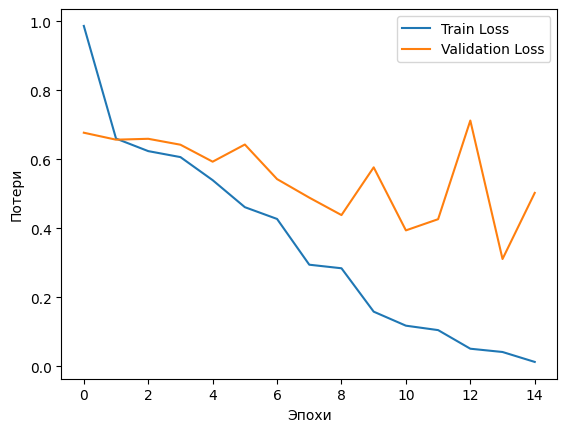

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

Матрица ошибок:
[[21  6]
 [11 13]]

Accuracy на тестовом множестве: 66.67 %
Test F1 Score: 0.6614
Test MAE: 0.3333

Classification Report:
              precision    recall  f1-score   support

      marvel       0.66      0.78      0.71        27
   star-wars       0.68      0.54      0.60        24

    accuracy                           0.67        51
   macro avg       0.67      0.66      0.66        51
weighted avg       0.67      0.67      0.66        51



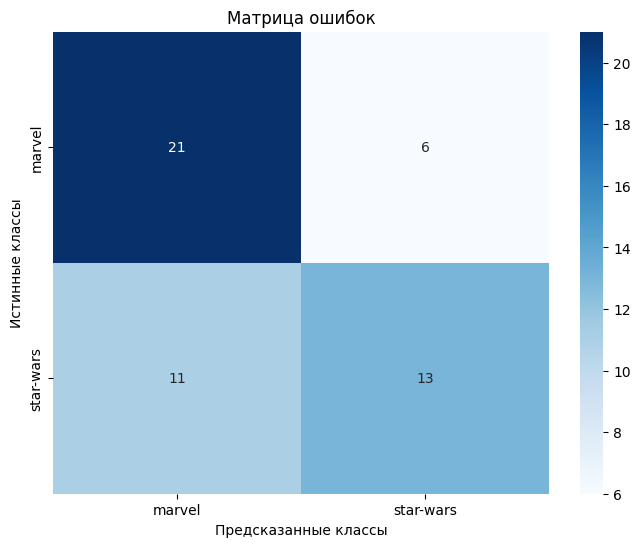

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            y_pred = model(images)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = test_model(model, test_loader)

accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
mae = mean_absolute_error(true_labels, predictions)

print('Матрица ошибок:')
print(conf_matrix)

print(f'\nAccuracy на тестовом множестве: {100*accuracy:.2f} %')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test MAE: {mae:.4f}\n')

print('Classification Report:')
print(classification_report(true_labels, predictions, target_names=classes))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'kr_model.pth')
print("Saved PyTorch Model State to kr_model.pth")

Saved PyTorch Model State to kr_model.pth


In [ ]:
kr_model = SimpleCNN(2)
kr_model.load_state_dict(torch.load('kr_model.pth'))

<ipython-input-53-8e0ad32a4e49>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kr_model.load_state_dict(torch.load('kr_model.pth'))


<All keys matched successfully>

Датасет 2:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/fruits.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2684/2684 [00:01<00:00, 2357.26it/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),    # Приводим к единому размеру
    transforms.ToTensor(),            # Преобразование в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
])

full_dataset = datasets.ImageFolder('/content/fruits', transform=transform)

train_size = int(0.7 * len(full_dataset))  # 70% для обучения
val_size = int(0.15 * len(full_dataset))   # 15% для валидации
test_size = len(full_dataset) - train_size - val_size  # Остальные 15% для теста

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

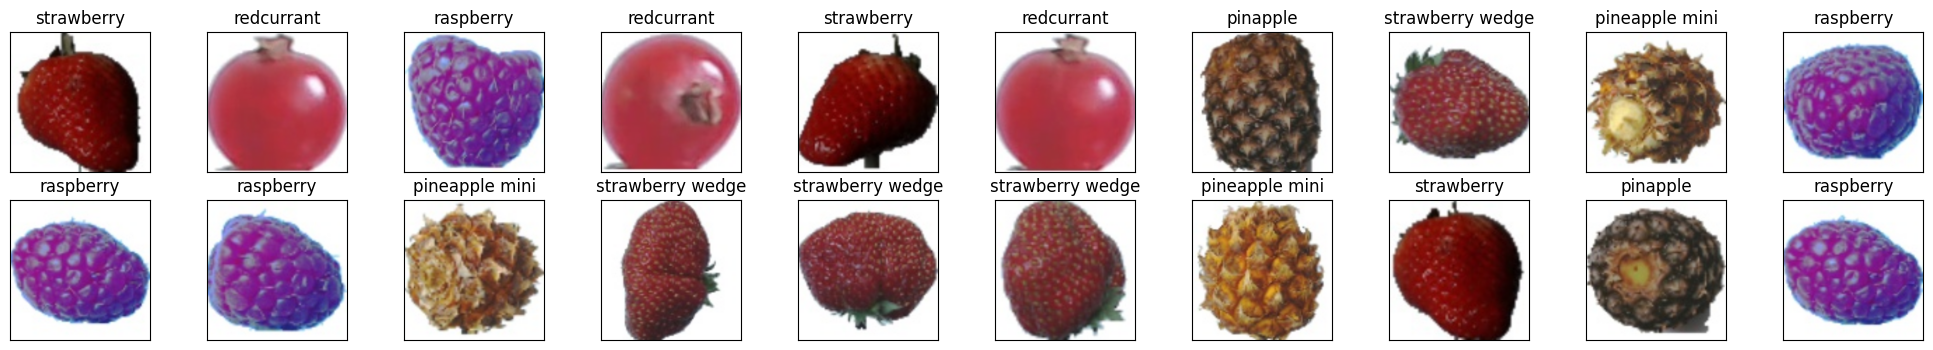

In [ ]:
classes = ['pinapple', 'pineapple mini', 'raspberry', 'redcurrant', 'strawberry', 'strawberry wedge']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

После resize:

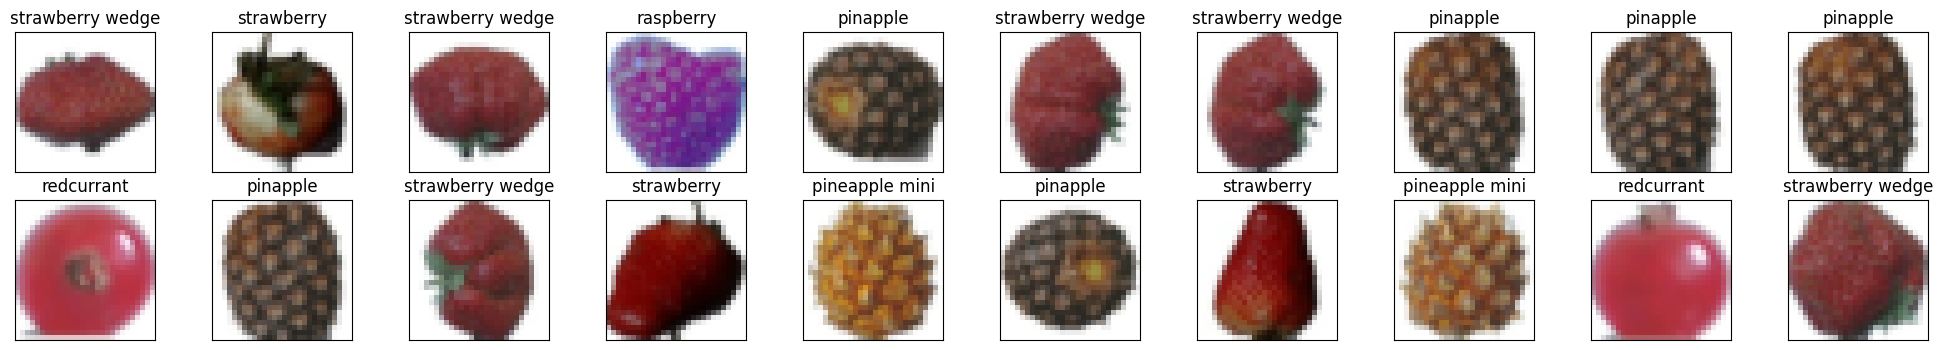

In [ ]:
classes = ['pinapple', 'pineapple mini', 'raspberry', 'redcurrant', 'strawberry', 'strawberry wedge']

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
!jupyter nbconvert --to html /content/DL_portfolio_Kyzyl_ool.ipynb

[NbConvertApp] Converting notebook /content/DL_portfolio_Kyzyl_ool.ipynb to html
[NbConvertApp] Writing 3354046 bytes to /content/DL_portfolio_Kyzyl_ool.html
